In [16]:
#Import necessary packages
import nest_asyncio
nest_asyncio.apply()
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import pandas as pd
import stan
import subprocess
import warnings
import networkx as nx
warnings.filterwarnings("ignore")

In [17]:
# The Hawkes process kernel used. Weibull Kernel
def kernel(p, t, beta):
    return (1.0-p)**(t**beta)-(1.0-p)**((t+1)**beta)

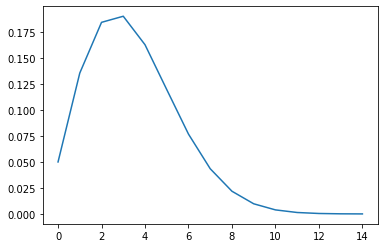

In [18]:
#Plot the Weibull distribution
p = 0.05
beta = 2.0
t = np.zeros(15)
f = np.zeros(15)

for i in range(len(t)):
    f[i] = kernel(p, i, beta)
plt.plot(f)
plt.show()

In [19]:
# Generate MHP's M=34
M=34
T=300
mu=np.random.rand(M)
mu=mu.reshape((M, 1))

p=0.05
beta=2.0

import networkx as nx
G = nx.karate_club_graph()
A=nx.to_numpy_array(G)
for i in range(34):
    A[i,i]=5.0

max_eval=np.linalg.eigvals(A)[0]

A=0.8*A/max_eval
print(A)

theta=A
print(theta)

def mvh_sim(mu, theta, p, beta, T, M):
    N=np.zeros([M,T])
    lam=np.zeros([M,T])

    for i in range(M):
        lam[i,0]=mu[i]
        N[i,0]=np.random.poisson(lam[i,0])

    for t in range(1,T):
        for i in range(M):
            lam[i,t]=mu[i]
            for j in range(M):
                for s in range(t):
                    lam[i,t]=lam[i,t]+theta[i,j]*kernel(p,t-s-1,beta)*N[j,s]
            N[i,t]=np.random.poisson(lam[i,t])
    return N,lam

N,lam=mvh_sim(mu, theta, p, beta, T, M)

[[0.14988253 0.11990603 0.14988253 ... 0.05995301 0.         0.        ]
 [0.11990603 0.14988253 0.17985904 ... 0.         0.         0.        ]
 [0.14988253 0.17985904 0.14988253 ... 0.         0.05995301 0.        ]
 ...
 [0.05995301 0.         0.         ... 0.14988253 0.11990603 0.11990603]
 [0.         0.         0.05995301 ... 0.11990603 0.14988253 0.14988253]
 [0.         0.         0.         ... 0.11990603 0.14988253 0.14988253]]
[[0.14988253 0.11990603 0.14988253 ... 0.05995301 0.         0.        ]
 [0.11990603 0.14988253 0.17985904 ... 0.         0.         0.        ]
 [0.14988253 0.17985904 0.14988253 ... 0.         0.05995301 0.        ]
 ...
 [0.05995301 0.         0.         ... 0.14988253 0.11990603 0.11990603]
 [0.         0.         0.05995301 ... 0.11990603 0.14988253 0.14988253]
 [0.         0.         0.         ... 0.11990603 0.14988253 0.14988253]]


In [20]:
#COmpute the ground truth mean diagonal and off-diagonal
off = []
diag = []
for i in range(34):
    for j in range(34):
        if i != j :
            off.append(theta[i,j])
        else:
            diag.append(theta[i,i])

In [21]:
print('{:.3f}'.format(np.mean(off)))
print('{:.3f}'.format(np.mean(diag)))

0.012
0.150


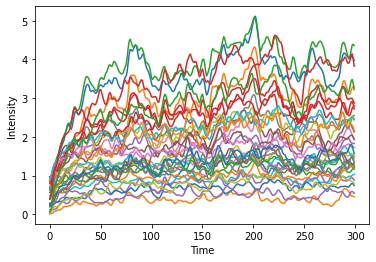

In [22]:
#Plot the intensity
plt.plot(np.transpose(lam))
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.savefig('intensity_karate.eps')
plt.show()

In [52]:
#Fix the nodes positions used later when plotting the network
layout_position = nx.spring_layout(G)

In [53]:
#FUnction to plot the network out of the genarted R matrix (called theta) out of the karate club graphs 
import networkx as nx

def plot_adj_matrix(theta, title, pos, filename = None):

    theta = np.round(theta, decimals=2)
    G = nx.from_numpy_array(theta)
    plt.show()

    self_loops = [(n, n) for n in G.nodes() if G.has_edge(n, n)]
    G.remove_edges_from(self_loops)

    
    #pos = nx.spring_layout(G)
    elarge = [(u,v) for (u,v,d) in G.edges(data = True) if d["weight"] > 0.1]
    esmall = [(u,v) for (u,v,d) in G.edges(data=True) if d["weight"] <= 0.1 and d["weight"] > 0.02]


    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width = 3)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width = 1, alpha = 0.5, edge_color='b', style='dashed')


    
    G1 = G.edge_subgraph(elarge).copy()
    G2 = G.edge_subgraph(esmall).copy()

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.title(title, size=20)

    
    if filename != None:
        plt.savefig(filename +'.eps')
    else:
        plt.show()
        

In [25]:
Naggr = np.sum(N, axis = 0)
ev, evec = np.linalg.eig(theta)
ev = np.real(ev)
evec = np.real(evec)
ev_max = np.max(ev)

In [26]:
#Estimate p and beta using Stan
model = """
data {
  int T;
  real N[T];
}
parameters {
  real<lower=0,upper=1> p;
  real<lower=0> beta;
  real<lower=0,upper=1> theta;
  real<lower=0> mu;
}
transformed parameters {
  vector[T] lam;

  lam[1] = mu;
  
  for (j in 2:T){
    lam[j]=mu;
    for(k in 1:(j-1)){
     lam[j] = lam[j]+theta*(pow(1.0-p,pow(j-k-1.0,beta))-pow(1.0-p,pow(j-k,beta)))*N[k];
    }
  }
}
model {
  theta ~ beta(1,1);
  p ~ beta(1,1);
  mu ~ cauchy(0,5); 
  beta ~ cauchy(0,5); 
  for (j in 1:T){
    target+=N[j]*log(lam[j])-lam[j];
  }
}
"""

In [27]:
data = {"T":300,"N": Naggr}
posterior = stan.build(model, data=data, random_seed=2)
fit = posterior.sample(num_chains=1, num_samples = 1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan__ipcsosu/model_xws5alzv.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1000/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), 

In [28]:
p_est = np.mean(fit['p'])
beta_est = np.mean(fit['beta'])

In [29]:
print('{:.3f}'.format(p_est), ['{:.3f}'.format(np.percentile(fit['p'], 5)), '{:.3f}'.format(np.percentile(fit['p'],95))])
print('{:.3f}'.format(beta_est), ['{:.3f}'.format(np.percentile(fit['beta'], 5)), '{:.3f}'.format(np.percentile(fit['beta'],95))])

0.041 ['0.003', '0.142']
2.317 ['1.191', '3.571']


In [30]:
# Create linear regression from the multivariate Hawkes

def exact_theta(theta, mu):
    M = np.shape(theta)[0]
    theta_vect = np.ones(M*(M+1))
    
    for i in range(M):
        theta_vect[i] = mu[i] #fill the first M elements of the vector 
    cnt = i  #set the cnt value to the last increment of the last loop
    
    for i in range(M):
        for j in range(M):
            cnt+=1
            theta_vect[cnt] = theta[i,j]
    
    return theta_vect

def coef_vec2mat(theta_vect, M):
    theta_est = np.zeros([M,M])
    mu_est = np.zeros(M)
    for i in range(M):
        mu_est[i] = theta_vect[i]
    cnt = i
    for i in range(M):
        for j in range(M):
            cnt+=1
            theta_est[i,j] = theta_vect[cnt]
    return mu_est, theta_est

def create_linear_system(N, p_est, beta_est):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*(M+1)])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                cnt2+=1
                for s in range(t):
                    X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
    return y, X

def create_linear_system_diag(N, p_est, beta_est):
    T = len(N)
    y = np.zeros(T)
    X = np.zeros([T,2])
    for t in range(T):
        y[t] = N[t]
        X[t,0] = 1.0
        for s in range(t):
            X[t,1] += N[s]*kernel(p_est, t-s-1, beta_est)
    return y, X


def create_linear_system_offdiag(N, p_est, beta_est, theta_diag):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*(M+1)])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                if i!=j:
                    cnt2+=1
                    for s in range(t):
                        X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
                else:
                    for s in range(t):
                        X[cnt,cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)*theta_diag[i]
    return y, X

def create_linear_system_fixdiag(N, p_est, beta_est, theta_diag):
    M = np.shape(N)[0]
    T = np.shape(N)[1]
    y = np.zeros(M*T)
    X = np.zeros([M*T, M*M])
    cnt = -1
    for t in range(T):
        cnt2 = M-1
        for i in range(M):
            cnt+=1
            y[cnt] = N[i,t]
            X[cnt,i] = 1.0
            for j in range(M):
                if i!=j:
                    cnt2+=1
                    for s in range(t):
                        X[cnt, cnt2] += N[j,s]*kernel(p_est, t-s-1, beta_est)
                else:
                    for s in range(t):
                        y[cnt] -= N[j,s]*kernel(p_est, t-s-1, beta_est)*theta_diag[i]
    return y, X

In [31]:
# Linear Estimate
def full_linear_estimate(N, p_est, beta_est, x, M):
    T = N.shape[1]
    N_train = (T//10)*x
    y, X = create_linear_system(N, p_est, beta_est)
    reg = LinearRegression(positive=True, fit_intercept=False).fit(X[0:N_train,:], y[0:N_train])
    mu_est, theta_est = coef_vec2mat(reg.coef_, M)
    
    yhat = np.matmul(X,reg.coef_)
    mse = np.mean((y[N_train:]-yhat[N_train:])**2) #mean squared error
    
    return mu_est, theta_est, mse

In [32]:
# Ridge estimate method (Ridge for diag_param = 1 and Ridge Diag for diag_param = 0)
def ridge_estimate(N, p_est, beta_est, x, diag_param, M, Nsamp):
    T = N.shape[1]
    N_train = (T//10)*x 
    y,X = create_linear_system(N, p_est, beta_est)
    pfac = np.ones(X.shape[1])
    if diag_param == 1:
        cnt = -1
        cnt2 = M-1
        for i in range(M):
            pfac[i]=0.0
            cnt+=1
            for j in range(M):
                cnt2+=1
                if i==j:
                    pfac[cnt2]=0.0
    pd.DataFrame([Nsamp]).to_csv('Nsamp.csv',index=False,header=False)
    pd.DataFrame(X).to_csv('X.csv',index=False,header=False)
    pd.DataFrame(y).to_csv('y.csv',index=False,header=False)
    pd.DataFrame(pfac).to_csv('pfac.csv',index=False,header=False)
   

    subprocess.call("Rscript mvhawkes_glmnet.R", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    ridge_coef=pd.read_csv("glm_coefs.csv")
    
    mu_est, theta_est = coef_vec2mat(ridge_coef['x'], M)

    yhat = np.matmul(X, ridge_coef['x'])

    mse = np.mean((y[N_train:]-yhat[N_train:])**2)

    return mu_est, theta_est, mse


In [33]:
#Elastic Net Estimate (Elastic Net for diag_param = 1 and Elastic Net Diag for diag_param = 0)
def ridge_estimate_lasso(N, p_est, beta_est, x, diag_param, M, Nsamp):
    T = N.shape[1]
    N_train = (T//10)*x
    y,X = create_linear_system(N, p_est, beta_est)
    pfac = np.ones(X.shape[1])
    if diag_param == 1:
        cnt = -1
        cnt2 = M-1
        for i in range(M):
            pfac[i]=0.0
            cnt+=1
            for j in range(M):
                cnt2+=1
                if i==j:
                    pfac[cnt2]=0.0
    pd.DataFrame([Nsamp]).to_csv('Nsamp.csv',index=False,header=False)
    pd.DataFrame(X).to_csv('X.csv',index=False,header=False)
    pd.DataFrame(y).to_csv('y.csv',index=False,header=False)
    pd.DataFrame(pfac).to_csv('pfac.csv',index=False,header=False)
   

    subprocess.call("Rscript mvhawkes_glmnet_lasso.R", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    ridge_coef=pd.read_csv("glm_coefs.csv")
    
    mu_est, theta_est = coef_vec2mat(ridge_coef['x'], M)

    yhat = np.matmul(X, ridge_coef['x'])

    mse = np.mean((y[N_train:]-yhat[N_train:])**2)

    return mu_est, theta_est, mse

In [34]:
#Staged1
def staged_estimate(N, p_est, beta_est, x, M):
    T = N.shape[1]
    N_train = x*(T//10)
    mu_diag=np.zeros(M)
    theta_diag=np.zeros(M)
    for i in range(M):
        y1,X1=create_linear_system_diag(N[i,:],p_est,beta_est)
        reg1 = LinearRegression(positive=True,fit_intercept=False).fit(X1[0:N_train,:], y1[0:N_train])
        
        mu_diag[i]=reg1.coef_[0]
        theta_diag[i]=reg1.coef_[1]
        
        
    yoff, Xoff = create_linear_system_offdiag(N,p_est,beta_est,theta_diag)
    regoff = LinearRegression(positive=True,fit_intercept=False).fit(Xoff[0:N_train,:], yoff[0:N_train])
    y_hatoff=np.matmul(Xoff,regoff.coef_)
    
    theta_est=np.zeros([M,M])
    mu_est=np.zeros(M)

    rho=regoff.coef_[-1]
    #print(rho)
    for i in range(M):
        mu_est[i]=regoff.coef_[i]
        theta_est[i,i]=rho*theta_diag[i]

    cnt2=i
    for i in range(M):
        for j in range(M):
            if i!=j:
                cnt2+=1
                theta_est[i,j]=regoff.coef_[cnt2]
            
            
    
    mse=np.mean((yoff[N_train:]-y_hatoff[N_train:])**2)
    
    return mu_est,theta_est,mse

In [35]:
#Staged2
def staged_fixed_estimate(N, p_est, beta_est, x, M):

    T = N.shape[1]
    N_train = (T//10)*x
    
    mu_diag = np.zeros(M)
    theta_diag = np.zeros(M)

    ybase = np.zeros(M*T)
    for i in range(M):
        y1, X1 = create_linear_system_diag(N[i,:], p_est, beta_est)
        reg1 = LinearRegression(positive=True, fit_intercept=False).fit(X1[0:N_train:],y1[0:N_train])

        mu_diag[i] = reg1.coef_[0]
        theta_diag[i] = reg1.coef_[1]
        
    yoff, Xoff = create_linear_system_fixdiag(N, p_est, beta_est, theta_diag)
    regoff = LinearRegression(positive=True, fit_intercept=False).fit(Xoff[0:N_train:],yoff[0:N_train])
    yhatoff = np.matmul(Xoff, regoff.coef_)

    theta_est = np.zeros([M,M])
    mu_est = np.zeros(M)

    for i in range(M):
        mu_est[i] = regoff.coef_[i]
        theta_est[i,i] = theta_diag[i]
    cnt2 = i
    for i in range(M):
        for j in range(M):
            if i!=j:
                cnt2+=1
                theta_est[i,j] = regoff.coef_[cnt2]

    mse = np.mean((yoff[N_train:]-yhatoff[N_train:])**2)

    return mu_est, theta_est, mse
                

In [41]:
# Run the Karate experiment with the different estimation methods over 100 simulation
Dfull = []
Drid  = []
Drid_lasso = []
Drid_lasso_diag = []
Dridiag = []
Dstage = []
Dfix = []


Ofull = []
Orid  = []
Orid_lasso = []
Orid_lasso_diag = []
Oridiag = []
Ostage = []
Ofix = []


mfull = []
mrid  = []
mrid_lasso = []
mrid_lasso_diag = []
mridiag = []
mstage = []
mfix = []


M = 34
Nsamp = 300
number_of_simulations = 100
x = 7

for k in range(number_of_simulations):
    N, lam = mvh_sim(mu, theta, p, beta, T, M)
    mu_full, theta_full, mse_full = full_linear_estimate(N, p_est, beta_est, x, M)
    mu_ridge_diag, theta_ridge_diag, mse_ridge_diag = ridge_estimate(N, p_est, beta_est, x, 1, M, Nsamp)
    mu_ridge, theta_ridge, mse_ridge = ridge_estimate(N,p_est, beta_est, x, 0, M, Nsamp)
    mu_ridge_lasso_diag, theta_ridge_lasso_diag, mse_ridge_lasso_diag = ridge_estimate_lasso(N, p_est, beta_est, x, 0, M, Nsamp)
    mu_ridge_lasso, theta_ridge_lasso, mse_ridge_lasso = ridge_estimate_lasso(N, p_est, beta_est, x, 1, M, Nsamp)
    mu_stage_fix, theta_stage_fix, mse_stage_fix = staged_fixed_estimate(N, p_est, beta_est, x, M)
    mu_stage, theta_stage, mse_stage = staged_estimate(N, p_est, beta_est, x, M)

    mfull.append(mse_full)
    mrid.append(mse_ridge)
    mridiag.append(mse_ridge_diag)
    mrid_lasso.append(mse_ridge_lasso)
    mrid_lasso_diag.append(mse_ridge_lasso_diag)
    mstage.append(mse_stage)
    mfix.append(mse_stage_fix)
    

    if k==0:
        theta1 = theta_full/number_of_simulations
        theta2 = theta_ridge/number_of_simulations
        theta3 = theta_ridge_lasso/number_of_simulations
        theta4 = theta_ridge_lasso_diag/number_of_simulations
        theta5 = theta_ridge_diag/number_of_simulations
        theta6 = theta_stage/number_of_simulations
        theta7 = theta_stage_fix/number_of_simulations
    else:
        theta1 += theta_full/number_of_simulations
        theta2 += theta_ridge/number_of_simulations
        theta3 += theta_ridge_lasso/number_of_simulations
        theta4 += theta_ridge_lasso_diag/number_of_simulations
        theta5 += theta_ridge_diag/number_of_simulations
        theta6 += theta_stage/number_of_simulations
        theta7 += theta_stage_fix/number_of_simulations
        
    for i in range(M):
        Dfull.append(theta_full[i,i])
        Drid.append(theta_ridge[i,i])
        Drid_lasso.append(theta_ridge_lasso[i,i])
        Drid_lasso_diag.append(theta_ridge_lasso_diag[i,i])
        Dridiag.append(theta_ridge_diag[i,i])
        Dstage.append(theta_stage[i,i])
        Dfix.append(theta_stage_fix[i,i])

        for j in range(M):
            if i!=j:
                Ofull.append(theta_full[i,j])
                Orid.append(theta_ridge[i,j])
                Orid_lasso.append(theta_ridge_lasso[i,j])
                Orid_lasso_diag.append(theta_ridge_lasso_diag[i,j])
                Oridiag.append(theta_ridge_diag[i,j])
                Ostage.append(theta_stage[i,j])
                Ofix.append(theta_stage_fix[i,j])
    
    print(k, np.mean(mfull), np.mean(mrid), np.mean(mridiag), np.mean(mrid_lasso), np.mean(mrid_lasso_diag), np.mean(mstage), np.mean(mfix))
    print(k, np.mean(Dfull), np.mean(Drid), np.mean(Dridiag),  np.mean(Drid_lasso), np.mean(Drid_lasso_diag), np.mean(Dstage), np.mean(Dfix))
    print(k, np.mean(Ofull), np.mean(Orid), np.mean(Oridiag), np.mean(Orid_lasso),  np.mean(Orid_lasso_diag), np.mean(Ostage), np.mean(Ofix))
    print('')

0 577.8258573494322 1.6710482147139696 1.6589224236675568 1.6454556949860268 1.6338719344971755 577.8258573494323 561.2777899901323
0 0.0 0.04592517493274782 0.12181001158521465 0.1325071860313142 0.040589135482602345 0.0 0.3366878284329892
0 0.14723530792700437 0.03464316767102395 0.025247299287668126 0.02349187328566399 0.03003424885099625 0.14723530792700437 0.1365248154140101

1 519.2459609816832 1.678750724452862 1.6723749947184117 1.6649394725158304 1.6472001641690388 518.8679430591878 482.489083145117
1 0.0 0.04532818403280748 0.11378690241401476 0.13222874495531817 0.03295684023282854 0.0 0.3078091323314905
1 0.15652086109428956 0.035205623695542136 0.024947298011707635 0.020876834732336213 0.030610171850491412 0.1562504359767874 0.14063490339996673

2 909.0935622964374 1.7115031373174654 1.7007723397343872 1.6939363727618446 1.6749012506045038 909.2647104015247 835.6140868546836
2 0.0 0.04410393952080652 0.11385486090340717 0.13515885816143433 0.03450702184223984 0.0 0.3085939

In [42]:
karate_table = {' ': ['Linear', 'Ridge', 'Ridge Diag', 'Elastic Net', 'Elastic Net Diag', 'Staged1', 'Staged2'],
               'Mean Squared Error': ['{:.3f}'.format(np.mean(mfull)), '{:.3f}'.format(np.mean(mrid)), '{:.3f}'.format(np.mean(mridiag)),
                                      '{:.3f}'.format(np.mean(mrid_lasso)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_diag)), '{:.3f}'.format(np.mean(mstage)), 
                                      '{:.3f}'.format(np.mean(mfix))],
              'R Diagonal': ['{:.3f}'.format(np.mean(Dfull)), '{:.3f}'.format(np.mean(Drid)), '{:.3f}'.format(np.mean(Dridiag)),
                             '{:.3f}'.format(np.mean(Drid_lasso)),
                                      '{:.3f}'.format(np.mean(Drid_lasso_diag)), '{:.3f}'.format(np.mean(Dstage)), 
                             '{:.3f}'.format(np.mean(Dfix))],
              'R Off diagonal': ['{:.3f}'.format(np.mean(Ofull)), '{:.3f}'.format(np.mean(Orid)), '{:.3f}'.format(np.mean(Oridiag)), 
                                 '{:.3f}'.format(np.mean(Orid_lasso)),
                                      '{:.3f}'.format(np.mean(Orid_lasso_diag)), '{:.3f}'.format(np.mean(Ostage)), 
                                 '{:.3f}'.format(np.mean(Ofix))]}

In [43]:
pd.DataFrame(karate_table)

,,Mean Squared Error,R Diagonal,R Off diagonal
0,Linear,798.080,0.004,0.191
1,Ridge,1.672,0.044,0.034
2,Ridge Diag,1.666,0.124,0.022
3,Elastic Net,1.664,0.152,0.017
4,Elastic Net Diag,1.639,0.039,0.030
5,Staged1,799.578,0.000,0.191
6,Staged2,752.316,0.297,0.177


In [44]:
import pandas as pd
table_karate = pd.DataFrame(karate_table)
table_karate.to_csv('Karate_simulation_results.csv', index = None)

In [63]:
#pd.read_csv('Karate_simulation_results.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


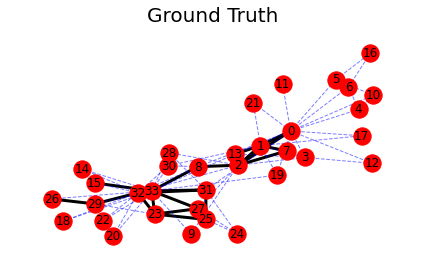

In [54]:
plot_adj_matrix(theta, 'Ground Truth', layout_position,  'ground_truth_karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


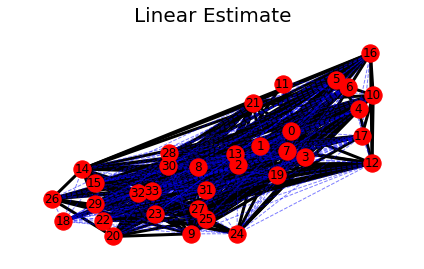

In [55]:
plot_adj_matrix(theta1, 'Linear Estimate', layout_position, 'Linear_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


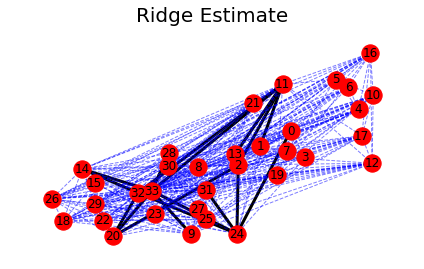

In [56]:
plot_adj_matrix(theta2, 'Ridge Estimate', layout_position, 'Ridge_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


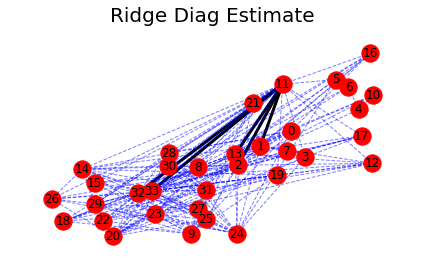

In [57]:
plot_adj_matrix(theta5, 'Ridge Diag Estimate', layout_position, 'Ridge_Diagonal_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


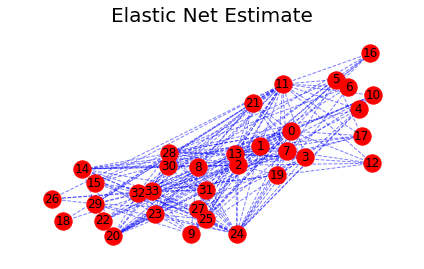

In [58]:
plot_adj_matrix(theta3, 'Elastic Net Estimate', layout_position, 'Elastic_Net_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


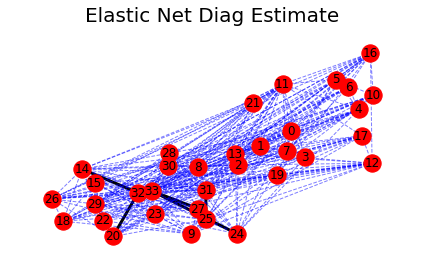

In [59]:
plot_adj_matrix(theta4, 'Elastic Net Diag Estimate', layout_position, 'Elastic_Net_Diagonal_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


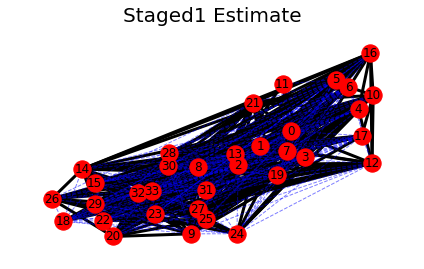

In [60]:
plot_adj_matrix(theta6, 'Staged1 Estimate', layout_position, 'Staged1_Estimate_Karate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


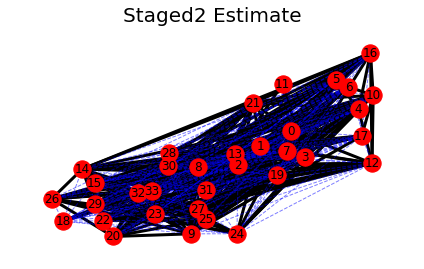

In [61]:
plot_adj_matrix(theta7, 'Staged2 Estimate', layout_position, 'Staged2_Estimate_Karate')

### Real Data experiment

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


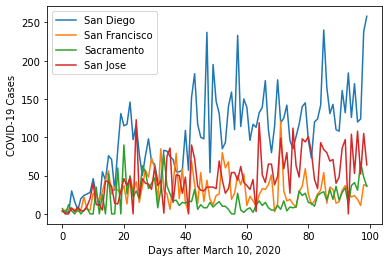

In [12]:
county_data = pd.read_csv('county_data.csv')
county_names = ['San Diego', 'San Francisco', 'Sacramento', 'San Jose']
county_data = np.array(county_data)

N_real_data = np.transpose(county_data)
plt.plot(N_real_data.transpose())
plt.legend(county_names)
plt.xlabel('Days after March 10, 2020')
plt.ylabel('COVID-19 Cases')
plt.savefig('real_data_covid_cases.eps')
plt.show()

In [13]:
Naggr_real_data = np.sum(N_real_data, axis=0)

In [16]:
hawkes_data = {"T": 100, "N": Naggr_real_data}
posterior = stan.build(model, data=hawkes_data, random_seed=2)
fit = posterior.sample(num_chains=1, num_samples = 1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan__ipcsosu/model_xws5alzv.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   0% (1/2000)
Sampling:   5% (100/2000)
Sampling:  10% (200/2000)
Sampling:  15% (300/2000)
Sampling:  20% (400/2000)
Sampling:  25% (500/2000)
Sampling:  30% (600/2000)
Sampling:  35% (700/2000)
Sampling:  40% (800/2000)
Sampling:  45% (900/2000)
Sampling:  50% (1001/2000)
Sampling:  55% (1100/2000)
Sampling:  60% (1200/2000)
Sampling:  65% (1300/2000)
Sampling:  70% (1400/2000)
Sampling:  75% (1500/2000)
Sampling:  80% (1600/2000)
Sampling:  85% (1700/2000)
Sampling:  90% (1800/2000)
Sampling:  95% (1900/2000)
Sampling: 100% (2000/2000)
Sampling: 100% (2000/2000), done.
Messages received dur

In [17]:
p_est_real_data = np.mean(fit['p'])
beta_est_real_data = np.mean(fit['beta'])

In [18]:
print('{:.4f}'.format(p_est_real_data), ['{:.4f}'.format(np.percentile(fit['p'], 5)), '{:.4f}'.format(np.percentile(fit['p'],95))])
print('{:.4f}'.format(beta_est_real_data), ['{:.4f}'.format(np.percentile(fit['beta'], 5)), '{:.4f}'.format(np.percentile(fit['beta'],95))])

0.0004 ['0.0001', '0.0010']
4.4769 ['3.8432', '5.1607']


In [19]:
#Compute the mean diagonal and off-diagonal of the reproduction matrix for the real data
Dfull = []
Drid  = []
Drid_lasso = []
Drid_lasso_diag = []
Dridiag = []
Dstage = []
Dfix = []
Dind = []

Ofull = []
Orid  = []
Orid_lasso = []
Orid_lasso_diag = []
Oridiag = []
Ostage = []
Ofix = []


mfull = []
mrid  = []
mrid_lasso = []
mrid_lasso_diag = []
mridiag = []
mstage = []
mfix = []
mind = []

M = 4
Nsamp = 100
x = 7
N = np.transpose(county_data)
p_est = p_est_real_data
beta_est = beta_est_real_data
    
mu_full, theta_full, mse_full = full_linear_estimate(N, p_est, beta_est, x, M)
mu_ridge_diag, theta_ridge_diag, mse_ridge_diag = ridge_estimate(N, p_est, beta_est, x, 1, M, Nsamp)
mu_ridge, theta_ridge, mse_ridge = ridge_estimate(N,p_est, beta_est, x, 0, M, Nsamp)
mu_ridge_lasso_diag, theta_ridge_lasso_diag, mse_ridge_lasso_diag = ridge_estimate_lasso(N, p_est, beta_est, x, 0, M, Nsamp)
mu_ridge_lasso, theta_ridge_lasso, mse_ridge_lasso = ridge_estimate_lasso(N, p_est, beta_est, x, 1, M, Nsamp)
mu_stage_fix, theta_stage_fix, mse_stage_fix = staged_fixed_estimate(N, p_est, beta_est, x, M)
mu_stage, theta_stage, mse_stage = staged_estimate(N, p_est, beta_est, x, M)


mfull.append(mse_full)
mrid.append(mse_ridge)
mridiag.append(mse_ridge_diag)
mrid_lasso.append(mse_ridge_lasso)
mrid_lasso_diag.append(mse_ridge_lasso_diag)
mstage.append(mse_stage)
mfix.append(mse_stage_fix)

    
for i in range(M):
    Dfull.append(theta_full[i,i])
    Drid.append(theta_ridge[i,i])
    Drid_lasso.append(theta_ridge_lasso[i,i])
    Drid_lasso_diag.append(theta_ridge_lasso_diag[i,i])
    Dridiag.append(theta_ridge_diag[i,i])
    Dstage.append(theta_stage[i,i])
    Dfix.append(theta_stage_fix[i,i])

    for j in range(M):
        if i!=j:
            Ofull.append(theta_full[i,j])
            Orid.append(theta_ridge[i,j])
            Orid_lasso.append(theta_ridge_lasso[i,j])
            Orid_lasso_diag.append(theta_ridge_lasso_diag[i,j])
            Oridiag.append(theta_ridge_diag[i,j])
            Ostage.append(theta_stage[i,j])
            Ofix.append(theta_stage_fix[i,j])

print(np.mean(mfull), np.mean(mrid), np.mean(mridiag), np.mean(mrid_lasso), np.mean(mrid_lasso_diag), np.mean(mstage), np.mean(mfix))
print(np.mean(Dfull), np.mean(Drid), np.mean(Dridiag),  np.mean(Drid_lasso), np.mean(Drid_lasso_diag), np.mean(Dstage), np.mean(Dfix))
print(np.mean(Ofull), np.mean(Orid), np.mean(Oridiag), np.mean(Orid_lasso),  np.mean(Orid_lasso_diag), np.mean(Ostage), np.mean(Ofix))
print('')

4322.362244291582 803.8081680329304 796.2724539124373 796.0724660730374 798.0375580582432 4105.583728275346 3992.5999999004457
0.4483270686733931 0.4416653166889912 0.6208055872053385 0.6489897021119593 0.5006551230159775 0.0 0.6762883913316802
0.33663733339026614 0.1659595959627317 0.09174873315223693 0.08281028987215547 0.1388734986022872 0.4073332746937619 0.2953828471101184



In [21]:
real_data_table = {' ': ['Linear', 'Ridge', 'Ridge Diag', 'Elastic Net', 'Elastic Net Diag', 'Staged1', 'Staged2'],
               'Mean Squared Error': ['{:.3f}'.format(np.mean(mfull)), '{:.3f}'.format(np.mean(mrid)), '{:.3f}'.format(np.mean(mridiag)),
                                      '{:.3f}'.format(np.mean(mrid_lasso)),
                                      '{:.3f}'.format(np.mean(mrid_lasso_diag)), '{:.3f}'.format(np.mean(mstage)), 
                                      '{:.3f}'.format(np.mean(mfix))],
              'R Diagonal': ['{:.3f}'.format(np.mean(Dfull)), '{:.3f}'.format(np.mean(Drid)), '{:.3f}'.format(np.mean(Dridiag)),
                             '{:.3f}'.format(np.mean(Drid_lasso)),
                                      '{:.3f}'.format(np.mean(Drid_lasso_diag)), '{:.3f}'.format(np.mean(Dstage)), 
                             '{:.3f}'.format(np.mean(Dfix))],
              'R Off diagonal': ['{:.3f}'.format(np.mean(Ofull)), '{:.3f}'.format(np.mean(Orid)), '{:.3f}'.format(np.mean(Oridiag)), 
                                 '{:.3f}'.format(np.mean(Orid_lasso)),
                                      '{:.3f}'.format(np.mean(Orid_lasso_diag)), '{:.3f}'.format(np.mean(Ostage)), 
                                 '{:.3f}'.format(np.mean(Ofix))]}

In [22]:
pd.DataFrame(real_data_table)

,,Mean Squared Error,R Diagonal,R Off diagonal
0,Linear,4322.362,0.448,0.337
1,Ridge,803.808,0.442,0.166
2,Ridge Diag,796.272,0.621,0.092
3,Elastic Net,796.072,0.649,0.083
4,Elastic Net Diag,798.038,0.501,0.139
5,Staged1,4105.584,0.000,0.407
6,Staged2,3992.600,0.676,0.295


In [23]:
import pandas as pd
table_real_data = pd.DataFrame(real_data_table)
table_real_data.to_csv('real_data_results.csv', index = None)

In [62]:
#pd.read_csv('real_data_results.csv')